### Import Packages

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d

import cubehelix

In [3]:
import matplotlib
from mpl_toolkits.mplot3d import axes3d   
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

#### Color Maps

In [4]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

#### Create SkyCoord Object for SN1987A with RA, Dec, Distance

In [5]:
# Properties of SN1987A
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [6]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.2697417)>
51400.0 pc


#### Read in GCNS Data and Turn Into SkyCoord Objects

In [7]:
# GCNS data: https://arxiv.org/abs/2012.02061
GCNS_file = '../GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

In [8]:
GCNS[0]

SOURCE_ID,RA,RA_ERROR,DEC,DEC_ERROR,PARALLAX,PARALLAX_ERROR,PMRA,PMRA_ERROR,PMDEC,PMDEC_ERROR,PHOT_G_MEAN_MAG,PHOT_G_MEAN_FLUX_OVER_ERROR,PHOT_BP_MEAN_MAG,PHOT_BP_MEAN_FLUX_OVER_ERROR,PHOT_RP_MEAN_MAG,PHOT_RP_MEAN_FLUX_OVER_ERROR,PHOT_BP_RP_EXCESS_FACTOR,RUWE,IPD_FRAC_MULTI_PEAK,ADOPTEDRV,ADOPTEDRV_ERROR,ADOPTEDRV_REFNAME,RADIAL_VELOCITY_IS_VALID,GCNS_PROB,WD_PROB,DIST_1,DIST_16,DIST_50,DIST_84,XCOORD_50,XCOORD_16,XCOORD_84,YCOORD_50,YCOORD_16,YCOORD_84,ZCOORD_50,ZCOORD_16,ZCOORD_84,UVEL_50,UVEL_16,UVEL_84,VVEL_50,VVEL_16,VVEL_84,WVEL_50,WVEL_16,WVEL_84,NAME_GUNN,REFNAME_GUNN,GMAG_GUNN,E_GMAG_GUNN,RMAG_GUNN,E_RMAG_GUNN,IMAG_GUNN,E_IMAG_GUNN,ZMAG_GUNN,E_ZMAG_GUNN,NAME_2MASS,J_M_2MASS,J_MSIG_2MASS,H_M_2MASS,H_MSIG_2MASS,K_M_2MASS,K_MSIG_2MASS,NAME_WISE,W1MPRO_PM_WISE,W1SIGMPRO_PM_WISE,W2MPRO_PM_WISE,W2SIGMPRO_PM_WISE,W3MPRO_WISE,W3SIGMPRO_WISE,W4MPRO_WISE,W4SIGMPRO_WISE
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,bytes19,bytes1,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes26,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,bytes17,float32,float32,float32,float32,float32,float32,bytes20,float32,float32,float32,float32,float32,float32,float32,float32
2334666126716440064,0.002564982563575165,0.03305146,-26.365349533717044,0.025003772,14.697489928162035,0.036980867,23.497263410380384,0.03679831,-62.33879357307064,0.029814068,15.777896,1586.0432,17.429918,150.53537,14.540719,689.3689,1.4738392,1.0100706,0,--,--,NaN,F,1.0,0.0,0.06764704276020642,0.06786521287704768,0.0680299025855775,0.0682120405546926,11.270205961681791,11.242922563288483,11.30037993441073,7.548916403129069,7.530641662244597,7.569127284674224,-66.66381300618053,-66.50243038594728,-66.8422935133243,--,--,--,--,--,--,--,--,--,PSO J000000.599-262154.883,2016arXiv161205560C,17.7956008911133,0.00987500045448542,16.548999786377,0.00380300008691847,15.058500289917,0.00312000000849366,14.3964004516602,0.00257300003431737,00000058-2621542,12.833,0.024,12.267,0.022,11.977,0.026,J000000.61-262155.2,11.799,0.012,11.606,0.009,11.1,0.128,9.074,--


In [9]:
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance = GCNS['DIST_50'] * u.kpc,
              frame = 'icrs')

In [10]:
c1[0]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (0.00256498, -26.36534953, 0.0680299)>

In [11]:
len(GCNS)

331312

#### Time Since Event Was Observed

In [12]:
t1 = Time.now()
dt = t1-t0

dt.to('year')

<Quantity 35.30991729 yr>

#### Ellipsoid Geometry

In [13]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center (half the distance from Earth to SN1987A, the two foci)
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # semi-major axis of ellipse
# first term is the distance along the major axis beyond Earth -- it is half the distance light would travel in the time since the event was observed
     
print(a-c) # should be half the value of dt above, but in lyr

17.654958643572172 lyr


#### GCNS Star Geometric Properties

In [14]:
d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

d2 = c1.separation_3d(c0) # dist from all GCNS stars to SN 1987A

In [15]:
# Q1. Has the star seen SN1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES
# left side is the distance from the star to SN 1987A
# right side is the distance from SN 1987A to Earth plus the extra distance light has travelled since it was observed


# Q2. Is it within the SETI Ellipsoid?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES
# left side is distance from SN 1987A to star plus distance from star to Earth
# right side is the major axis (the sum of the two focal point distances for all points on an ellipse/ellipsoid is equal to the major axis length)

# Q3. Is it within some toleratnce of being ON the ellipse?
# Either a range of distance of time
tol = 0.1 # lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol
# check if sum of focal point distances minus the major axis diameter is within the interval (-tol, tol)

In [16]:
print('Total number of stars in GCNS:', len(d1))
print('Number of stars that have seen SN1987A:', sum(SNYES))
print('Number of stars that have not seen SN1987A:', sum(SNNO))
print('Number of stars within SETI Ellipsoid:', sum(EYES))
print('Number of stars within ' + str( tol ) + ' lyr of ellipsoid:', sum(OYES))

Total number of stars in GCNS: 331312
Number of stars that have seen SN1987A: 192518
Number of stars that have not seen SN1987A: 138794
Number of stars within SETI Ellipsoid: 25844
Number of stars within 0.1 lyr of ellipsoid: 150


In [17]:
print('Fraction of GCNS stars that have seen SN1987A:', sum(SNYES) / len(d1))
print('Fraction of GCNS stars that have not seen SN1987A:', sum(SNNO) / len(d1))
print('Fraction of GCNS stars within SETI Ellipsoid:', sum(EYES) / len(d1))

Fraction of GCNS stars that have seen SN1987A: 0.5810776548993094
Fraction of GCNS stars that have not seen SN1987A: 0.4189223451006906
Fraction of GCNS stars within SETI Ellipsoid: 0.07800502245617424


## Plotting

Text(0.5, 0, 'Z (pc)')

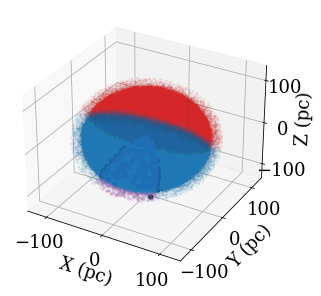

In [18]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(GCNS['XCOORD_50'][SNNO], GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.05, rasterized=True)
ax.scatter(GCNS['XCOORD_50'][SNYES], GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.05, rasterized=True)
ax.scatter(GCNS['XCOORD_50'][EYES], GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(GCNS['XCOORD_50'][OYES], GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

Text(0, 0.5, 'Z (pc)')

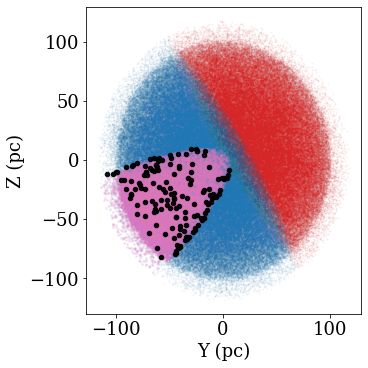

In [19]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()

ax.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.05, rasterized=True)
ax.scatter(GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.05, rasterized=True)
ax.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

ax.set_xlabel('Y (pc)')
ax.set_ylabel('Z (pc)')

## Another way of looking at it in terms of time

In [20]:
# The ellipsoid is d2 + r = 2c + time (focal point distances equals major axis)
# So we can rewrite this as time = d2 + r - 2c

etime = d2.to('lyr') + d1.to('lyr') - (2*c)

x10 = np.abs(GCNS['XCOORD_50']) < 10 # 'slice' through GCNS, with galactocentric |X| < 10 pc

In [21]:
sum(x10)

47484

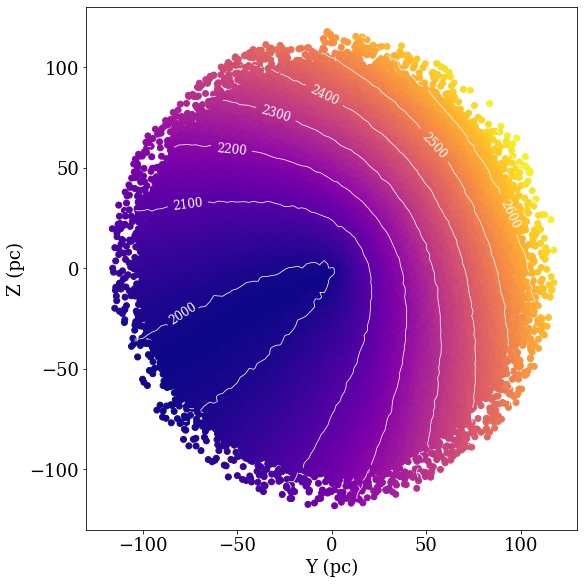

In [22]:
H, xe, ye, bn = binned_statistic_2d(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10],
                                    values = etime[x10].value + t0.decimalyear, 
                                    statistic='mean', bins=100) # mean binning for contours
XX, YY = np.meshgrid(xe, ye)


plt.figure(figsize=(8,8), constrained_layout=True)
plt.scatter(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10],
            c=(etime[x10].value + t0.decimalyear), cmap=plt.cm.plasma, rasterized=True)
# contour (c) is the time (d2 + r - 2c) plus the time when the event was observed on Earth (1987)

cs = plt.contour(xe[1:], ye[1:], H.T, colors='w', linewidths=0.75) # binned contours
plt.clabel(cs, fontsize=12)



plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.xlim(-130, 130)
plt.ylim(-130,130)
plt.show()

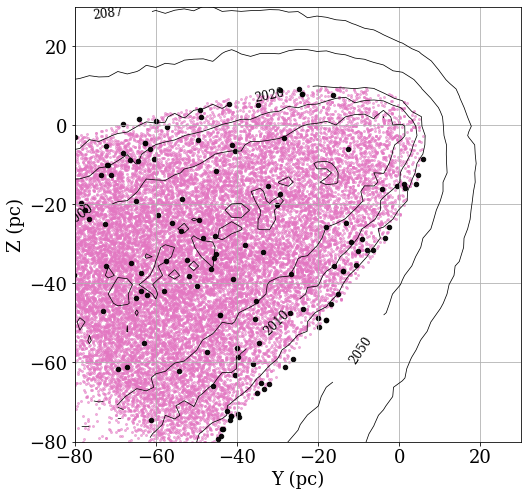

In [90]:
plt.figure(figsize=(8,8))

plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=0.75, levels=[1990, 2000, 2010, 2020, 2050, 2087])
plt.clabel(cs, fontsize=12)

plt.xlim(-80, 30)
plt.ylim(-80, 30)
plt.grid(True)

Text(0, 0.5, 'Z (pc)')

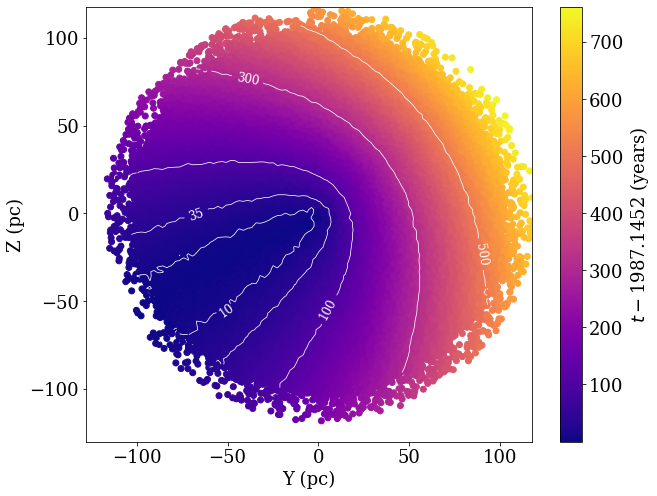

In [26]:
H, xe, ye, bn = binned_statistic_2d(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10],
                                    values = etime[x10].value, statistic='mean', bins=100)
XX, YY = np.meshgrid(xe, ye)

plt.figure(figsize=(10,8))
plt.scatter(GCNS['YCOORD_50'][x10], GCNS['ZCOORD_50'][x10],
            c=(etime[x10].value), cmap=plt.cm.plasma)
cb = plt.colorbar()
cb.set_label('$t - $'+format(t0.decimalyear, '7.4f') + ' (years)')

cs = plt.contour(xe[1:], ye[1:], H.T, colors='w', linewidths=0.75, levels=[10,35,100,300,500])
plt.clabel(cs, fontsize=12)


plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')